In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares, fmin


%matplotlib inline


In [92]:
SeboLMC_raw = pd.read_csv("data/SeboLMC.csv", header = None, names = ["Name","RAh","RAm","RAs","DEd","DEm","DEs","De1V","Period","Bmag","Vmag","Rmag","Imag"])
SeboLMC_raw

,Name,RAh,RAm,RAs,DEd,DEm,DEs,De1V,Period,Bmag,Vmag,Rmag,Imag
0,Evs HV12717,4,43,20.81,-69,13,48.0,0.07,8.84,15.48,14.69,14.20,13.91
1,Evs HV12724,4,46,1.04,-69,38,56.1,0.07,13.74,15.72,14.77,14.21,13.74
2,Evs U1,4,47,6.86,-69,17,39.7,0.07,22.56,15.02,14.09,13.62,13.09
3,Evs HV12447,4,47,24.05,-69,43,19.4,0.13,3.59,16.36,15.84,15.29,15.10
4,Evs HV12452,4,48,51.35,-69,21,22.9,0.06,8.74,15.53,14.77,14.40,13.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Evs HV12066,5,50,42.89,-69,36,0.8,0.17,3.97,15.99,15.43,15.07,14.75
601,Evs HV6065,5,50,57.05,-69,40,31.2,0.07,6.84,15.93,15.20,14.78,14.40
602,Evs HV12068,5,51,51.46,-69,44,10.7,0.17,2.29,16.46,16.05,15.67,15.44
603,Evs HV12700,5,57,31.45,-67,37,29.4,0.07,8.15,15.68,14.86,14.49,14.11


In [93]:
mask = SeboLMC_raw['Period'] > 0

In [94]:
SeboLMC = SeboLMC_raw[mask]

In [95]:
SeboLMC.shape

(598, 13)

Text(0.5, 1.0, 'P-L relation of Cepheids in LMC')

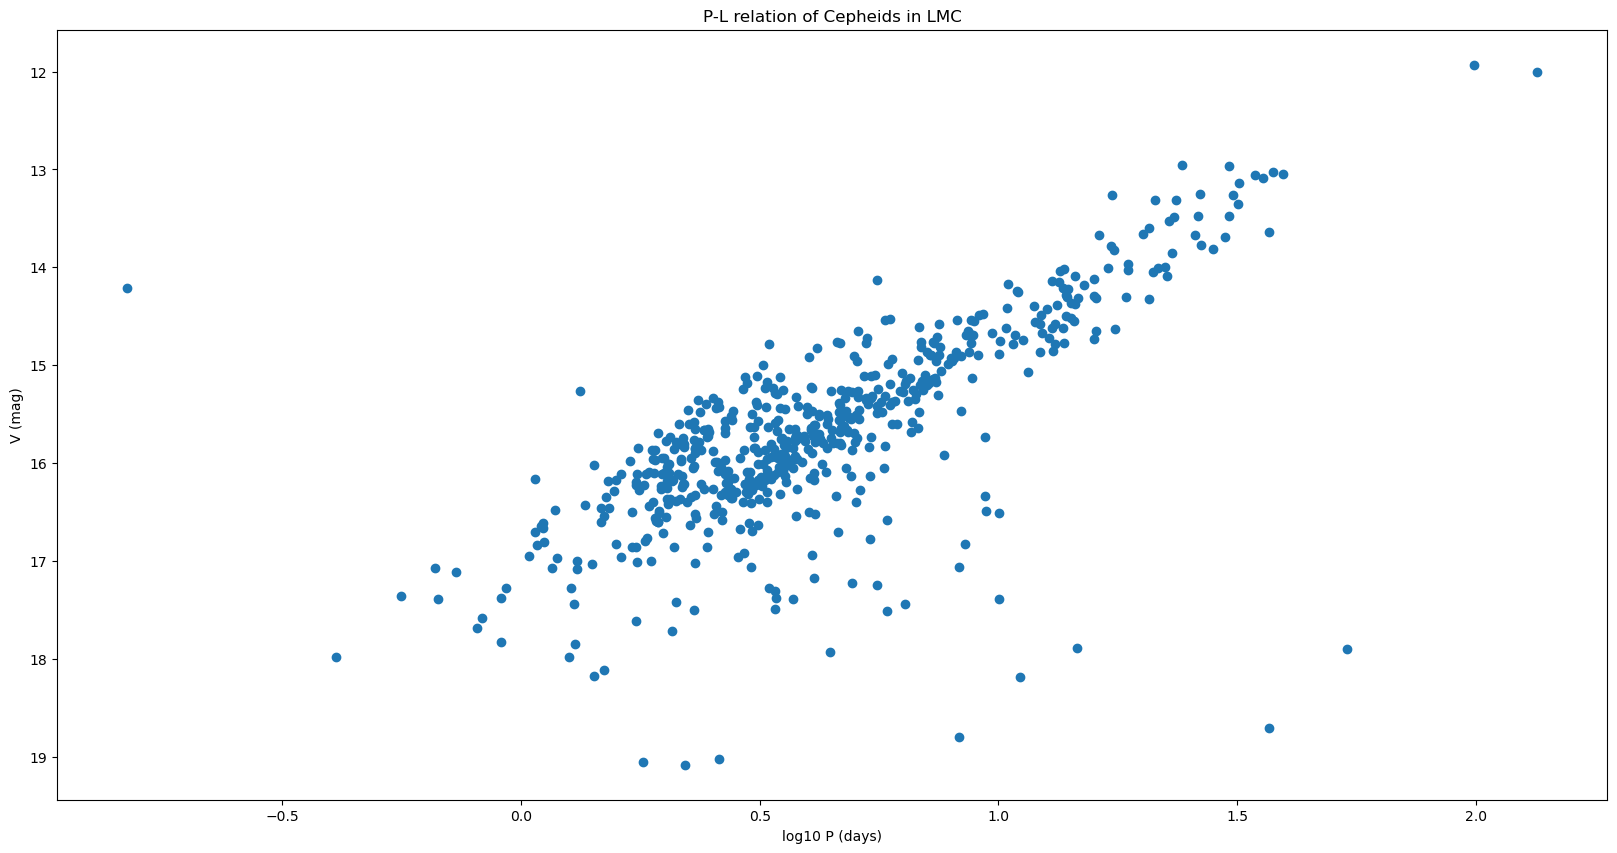

In [96]:
plt.figure(figsize = (20,10))
plt.scatter(np.log10(SeboLMC['Period']),SeboLMC['Vmag'])
plt.gca().invert_yaxis()
plt.xlabel('log10 P (days)')
plt.ylabel('V (mag)')
plt.title('P-L relation of Cepheids in LMC')

Guess for $c_1$ and $c_2$ is -2 and 19.3.

For slope estimate I looked at the points aligining with 0 and 1 on x axis and looking at the y value of the point lying a the middle of those points. At 0, average y value I estimated to be 17 and at 1 it was 15, so I took a difference of 15 and 17. 

For intercept I mentally drawn a line through the points and extended it to the y axis. 19.2 is an approximate value I found this way. 

In [114]:
def linear_fit(c1,c2):
    #Function constructing linear equation on given parameters
    def func(x):
        #Function evaluating the linear equation on given x values
        return c1 + c2*x
    return func

In [144]:
def quadratic_fit(c1,c2,c3):
    #Function constructing quadratic equation on given parameters
    def func(x):
        #Function evaluating the linear equation on given x values
        return c1 + c2*x + c3*x**2
    return func

In [155]:
def chisq(c1,c2, x, y, dy):
    
    evalPolyFunc = linear_fit(c1,c2)

    yModel = evalPolyFunc(x)

    chisqValue = np.sum( ((yModel - y) / dy)**2 )
    
    return chisqValue

In [151]:
def chisq_quad(c1,c2,c3, x, y, dy):
    
    evalPolyFunc = quadratic_fit(c1,c2,c3)

    yModel = evalPolyFunc(x)

    chisqValue = np.sum( ((yModel - y) / dy)**2 )
    
    return chisqValue

In [ ]:
def optimize(pars, )

In [221]:
c1 = 19.3
c2 = -2
x = np.log10(SeboLMC['Period'])
y = SeboLMC['Vmag']
dy = 0.2

In [222]:
print('Chi Squared value is: ', chisq(c1,c2,x,y,dy))

Chi Squared value is:  90698.77946009199


In [223]:
c1_guess = np.linspace(15,25,100)

In [224]:
for child in c1_guess:
    print('Chi Squared value is: ', chisq(child,c2,x,y,dy), 'with c1 guess', child)

Chi Squared value is:  63297.900950298324 with c1 guess 15.0
Chi Squared value is:  57600.66845918321 with c1 guess 15.1010101010101
Chi Squared value is:  52208.50687919951 with c1 guess 15.202020202020202
Chi Squared value is:  47121.41621034742 with c1 guess 15.303030303030303
Chi Squared value is:  42339.39645262678 with c1 guess 15.404040404040405
Chi Squared value is:  37862.447606037735 with c1 guess 15.505050505050505
Chi Squared value is:  33690.56967058019 with c1 guess 15.606060606060606
Chi Squared value is:  29823.762646254094 with c1 guess 15.707070707070708
Chi Squared value is:  26262.026533059587 with c1 guess 15.808080808080808
Chi Squared value is:  23005.361330996595 with c1 guess 15.909090909090908
Chi Squared value is:  20053.76704006507 with c1 guess 16.01010101010101
Chi Squared value is:  17407.243660265107 with c1 guess 16.11111111111111
Chi Squared value is:  15065.791191596658 with c1 guess 16.21212121212121
Chi Squared value is:  13029.409634059655 with c1 

In [225]:
c1_opt = 16.9
c2_guess = np.linspace(-1,-4,100)

In [226]:
for child in c2_guess:
    print('Chi Squared value is: ', chisq(c1_opt,child,x,y,dy), 'with c1 guess', child)

Chi Squared value is:  14655.435323497695 with c1 guess -1.0
Chi Squared value is:  14199.541002580727 with c1 guess -1.0303030303030303
Chi Squared value is:  13758.08293761071 with c1 guess -1.0606060606060606
Chi Squared value is:  13331.061128587658 with c1 guess -1.0909090909090908
Chi Squared value is:  12918.475575511555 with c1 guess -1.121212121212121
Chi Squared value is:  12520.326278382403 with c1 guess -1.1515151515151516
Chi Squared value is:  12136.613237200212 with c1 guess -1.1818181818181819
Chi Squared value is:  11767.336451964979 with c1 guess -1.2121212121212122
Chi Squared value is:  11412.495922676702 with c1 guess -1.2424242424242424
Chi Squared value is:  11072.091649335376 with c1 guess -1.2727272727272727
Chi Squared value is:  10746.123631941013 with c1 guess -1.303030303030303
Chi Squared value is:  10434.5918704936 with c1 guess -1.3333333333333335
Chi Squared value is:  10137.496364993143 with c1 guess -1.3636363636363638
Chi Squared value is:  9854.8371

In [227]:
c2_opt = -1.97

In [228]:
model = linear_fit(c1_opt,c2_opt)

In [261]:
#pars = np.poly1d(np.polyfit(x, y, 2))
np.polyfit(x, y, 2)


array([-0.48266897, -1.36014928, 16.78689007])

In [337]:
c3_guess_quad = np.linspace(10,25,100)
c2_quad = 0
c1_quad = 0

In [338]:
chivalues_quad = []
for child in c3_guess_quad:
    result = chisq_quad(c1_quad,c2_quad, child,x,y,dy)
    chivalues_quad.append(result)
    print('Chi Squared value is: ', result, 'with c1 guess', child)
print('Best Value for c3 is ',  c3_guess_quad[np.array([chivalues_quad]).argmin()])
    #print('Chi Squared value is: ', chisq_quad(child,c2_quad, c3_quad,x,y,dy), 'with c1 guess', child)

Chi Squared value is:  2236828.1628786633 with c1 guess 10.0
Chi Squared value is:  2228527.829371323 with c1 guess 10.151515151515152
Chi Squared value is:  2220636.3207681603 with c1 guess 10.303030303030303
Chi Squared value is:  2213153.637069176 with c1 guess 10.454545454545455
Chi Squared value is:  2206079.7782743685 with c1 guess 10.606060606060606
Chi Squared value is:  2199414.744383739 with c1 guess 10.757575757575758
Chi Squared value is:  2193158.5353972875 with c1 guess 10.90909090909091
Chi Squared value is:  2187311.151315014 with c1 guess 11.06060606060606
Chi Squared value is:  2181872.5921369176 with c1 guess 11.212121212121213
Chi Squared value is:  2176842.8578629987 with c1 guess 11.363636363636363
Chi Squared value is:  2172221.948493258 with c1 guess 11.515151515151516
Chi Squared value is:  2168009.864027695 with c1 guess 11.666666666666666
Chi Squared value is:  2164206.6044663093 with c1 guess 11.818181818181818
Chi Squared value is:  2160812.1698091016 with 

In [326]:
c3_opt_quad = c3_guess_quad[np.array([chivalues_quad]).argmin()]
c3_opt_quad

13.181818181818182

In [330]:
c2_guess_quad = np.linspace(-30,30,500)

In [331]:
chivalues_quad = []
for child in c2_guess_quad:
    result = chisq_quad(c1_quad,child, c3_opt_quad,x,y,dy)
    chivalues_quad.append(result)
    print('Chi Squared value is: ', result, 'with c2 guess', child)
print('Best Value for c2 is ',  c2_guess_quad[np.array([chivalues_quad]).argmin()])
    #print('Chi Squared value is: ', chisq_quad(child,c2_quad, c3_quad,x,y,dy), 'with c1 guess', child)

Chi Squared value is:  11725040.142017432 with c2 guess -30.0
Chi Squared value is:  11658415.699847098 with c2 guess -29.879759519038075
Chi Squared value is:  11592018.54952626 with c2 guess -29.759519038076153
Chi Squared value is:  11525848.691054903 with c2 guess -29.639278557114228
Chi Squared value is:  11459906.124433037 with c2 guess -29.519038076152306
Chi Squared value is:  11394190.84966066 with c2 guess -29.39879759519038
Chi Squared value is:  11328702.866737768 with c2 guess -29.278557114228455
Chi Squared value is:  11263442.175664369 with c2 guess -29.158316633266534
Chi Squared value is:  11198408.776440455 with c2 guess -29.03807615230461
Chi Squared value is:  11133602.66906603 with c2 guess -28.917835671342687
Chi Squared value is:  11069023.853541095 with c2 guess -28.79759519038076
Chi Squared value is:  11004672.329865646 with c2 guess -28.677354709418836
Chi Squared value is:  10940548.098039687 with c2 guess -28.557114228456914
Chi Squared value is:  10876651.

In [332]:
c2_opt_quad = c2_guess_quad[np.array([chivalues_quad]).argmin()]
c2_opt_quad

5.350701402805612

In [335]:
c1_guess_quad = np.linspace(-50,50,500)

In [336]:
chivalues_quad = []
for child in c3_guess_quad:
    result = chisq_quad(child,c2_opt_quad, c3_opt_quad,x,y,dy)
    chivalues_quad.append(result)
    print('Chi Squared value is: ', result, 'with c1 guess', child)
print('Best Value for c1 is ',  c1_guess_quad[np.array([chivalues_quad]).argmin()])
    #print('Chi Squared value is: ', chisq_quad(child,c2_quad, c3_quad,x,y,dy), 'with c1 guess', child)

Chi Squared value is:  1817276.697309698 with c1 guess 10.0
Chi Squared value is:  1838606.8006310458 with c1 guess 10.151515151515152
Chi Squared value is:  1860623.313502439 with c1 guess 10.303030303030303
Chi Squared value is:  1883326.2359238784 with c1 guess 10.454545454545455
Chi Squared value is:  1906715.5678953636 with c1 guess 10.606060606060606
Chi Squared value is:  1930791.309416895 with c1 guess 10.757575757575758
Chi Squared value is:  1955553.4604884721 with c1 guess 10.90909090909091
Chi Squared value is:  1981002.021110095 with c1 guess 11.06060606060606
Chi Squared value is:  2007136.9912817643 with c1 guess 11.212121212121213
Chi Squared value is:  2033958.3710034788 with c1 guess 11.363636363636363
Chi Squared value is:  2061466.1602752402 with c1 guess 11.515151515151516
Chi Squared value is:  2089660.3590970463 with c1 guess 11.666666666666666
Chi Squared value is:  2118540.967468899 with c1 guess 11.818181818181818
Chi Squared value is:  2148107.9853907973 with

In [314]:
c3_opt_quad = c3_guess_quad[np.array([chivalues_quad]).argmin()]
c3_opt_quad

-0.27054108216432926

In [315]:
quad_opt = np.array([c3_opt_quad,c2_opt_quad,c1_opt_quad])
quad_opt

array([-0.27054108, -0.41482966, 15.60606061])

In [316]:
model_quad = np.poly1d(quad_opt)
polyline = np.linspace(-0.5,2,100)

In [317]:
chisq_quad(c1_opt_quad,c2_opt_quad, c3_opt_quad,x,y,dy)

13428.439427018542

In [318]:
pars = np.poly1d(np.polyfit(x, y, 2))
pars

poly1d([-0.48266897, -1.36014928, 16.78689007])

Text(0.5, 1.0, 'P-L relation of Cepheids in LMC')

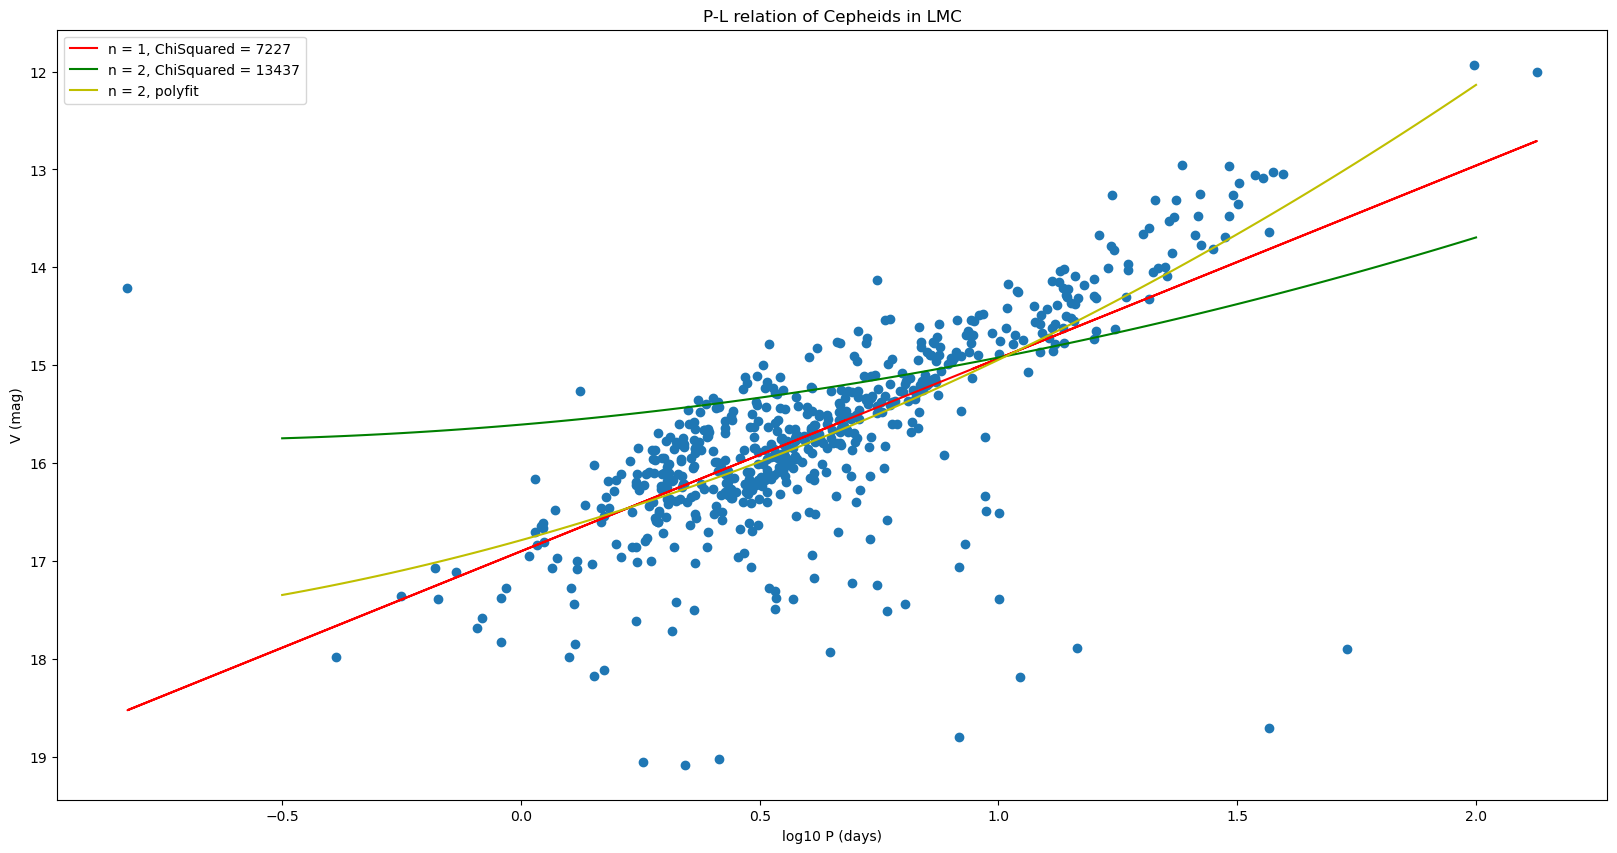

In [319]:
plt.figure(figsize = (20,10))
plt.scatter(np.log10(SeboLMC['Period']),SeboLMC['Vmag'])
plt.plot(x, model(x), color = 'r', label = 'n = 1, ChiSquared = 7227')
plt.plot(polyline, model_quad(polyline), color = 'g', label = 'n = 2, ChiSquared = 13437')
plt.plot(polyline, pars(polyline), color = 'y', label = 'n = 2, polyfit')
plt.gca().invert_yaxis()
plt.xlabel('log10 P (days)')
plt.ylabel('V (mag)')
plt.legend()
plt.title('P-L relation of Cepheids in LMC')